In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [59]:
df = pd.read_parquet("../kaggle_data/prices_AAPL.parquet")
df.drop(columns=['volume'],inplace=True)
df.sort_values(by='day_date', ascending=True, inplace=True)

,day_date,close_value,open_value,high_value,low_value
1258,2015-01-01,110.38,112.82,113.13,110.21
1257,2015-01-02,109.33,111.39,111.44,107.35
1259,2015-01-03,109.33,111.39,111.44,107.35
1260,2015-01-04,109.33,111.39,111.44,107.35
1256,2015-01-05,106.25,108.29,108.65,105.41
...,...,...,...,...,...
2,2019-12-27,289.80,291.12,293.97,288.12
1824,2019-12-28,289.80,291.12,293.97,288.12
1825,2019-12-29,289.80,291.12,293.97,288.12
1,2019-12-30,291.52,289.46,292.69,285.22


In [ ]:
df = df.reset_index(drop=True)
df.set_index("day_date",inplace=True)
print(df.head())

In [68]:
# df = pd.read_csv("../kaggle_data/CompanyValues.csv")
# df = df[df['ticker_symbol']=="AAPL"]
# df = df[(df["day_date"]>="2015-01-01") & (df["day_date"]<="2019-12-31")]
# df.drop(columns=['volume',"ticker_symbol"],inplace=True)
# df.sort_values(by='day_date', ascending=True, inplace=True)
# df.set_index("day_date",inplace=True)
# df

,close_value,open_value,high_value,low_value
day_date,,,,
2015-01-01,110.38,112.82,113.13,110.21
2015-01-02,109.33,111.39,111.44,107.35
2015-01-03,109.33,111.39,111.44,107.35
2015-01-04,109.33,111.39,111.44,107.35
2015-01-05,106.25,108.29,108.65,105.41
...,...,...,...,...
2019-12-27,289.80,291.12,293.97,288.12
2019-12-28,289.80,291.12,293.97,288.12
2019-12-29,289.80,291.12,293.97,288.12


In [69]:
data = sc.fit_transform(df)


train_ind = int(0.6*len(df))
val_ind = train_ind + int(0.2*len(df))

train = data[:train_ind]
val = data[train_ind:val_ind]
test = data[val_ind:]

print("--shapes--")
print("train,test,val",train.shape, test.shape, val.shape)

xtrain,ytrain,xval,yval,xtest,ytest = train[:,:4],train[:,0],val[:,:4],val[:,0],test[:,:4],test[:,0]

lookback = 60
n_features = 4
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60, 600)           1452000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 700)               3642800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 701       
Total params: 5,095,501
Trainable params: 5,095,501
Non-trainable params: 0
_________________________________________________________________
None
start: 0
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and '

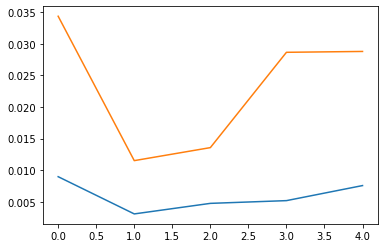

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
r2_score: -2.0933579298484486


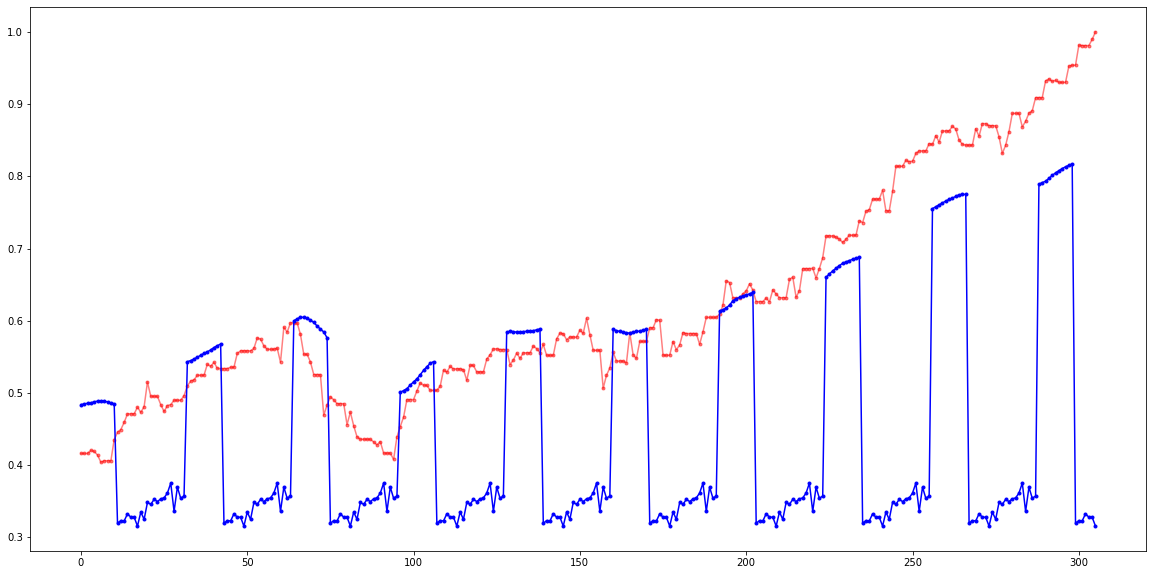

In [71]:
model = Sequential()
model.add(LSTM(600,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(700))
model.add(Dropout(0.15))
model.add(Dense(1))
print(model.summary())

model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs = 5, batch_size=64,
# history = model.fit(x_train,y_train, epochs = 100, batch_size=32,
          validation_data=(x_val,y_val),verbose = 1,
          shuffle = False, callbacks=[earlystop])
print("end:",time()-start)

model.save("./models/model-vadercase_sl.h5")
loss = history.history

plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.savefig("./loss-vadercase_sl.jpg")
plt.show()
y_pred = model.predict(x_test)
print("r2_score:",r2_score(y_pred,y_test))


plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.savefig("./result-vadercase_sl.jpg")
plt.show()

In [73]:
print("x_val", x_val.shape)
print("y_val", y_val.shape)
type(x_train)

x_val (305, 60, 4)
y_val (305,)


numpy.ndarray